In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
import os


data = []
labels = []
IMG_SIZE = 224
for i in os.listdir('/kaggle/input/nn23-sports-image-classification/Train'):
    img = cv.imread('/kaggle/input/nn23-sports-image-classification/Train/'+i)
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    img = cv.resize(img,(IMG_SIZE,IMG_SIZE))
    data.append(img)
    labels.append(i.split('_')[0])

print(len(data))
print(labels[0])

1681
Yoga


# Preprocessing

In [19]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
train_labels = le.fit_transform(labels)
train_labels = np_utils.to_categorical(train_labels, len(np.unique(train_labels)))

# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(np.array(data), np.array(train_labels), test_size=0.20, random_state=42)

# normalize the data
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0

print(len(trainX))
print(len(testX))

1344
337


# Data Augmentation

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
train_gen = train_datagen.flow(trainX,trainY,batch_size=32)

# Model

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

model = Sequential()
l2 = tf.keras.regularizers.l2(0.01)
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,3)))
model.add(MaxPool2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(512,(3,3),activation='relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu', kernel_regularizer=l2))
model.add(Dropout(0.3))
model.add(Dense(6,activation='softmax'))

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 24, 24, 64)       

In [23]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

checkpoint = ModelCheckpoint('model.h5',monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=False,mode='auto',period=1)
early = EarlyStopping(monitor='val_loss',min_delta=0,patience=20,verbose=1,mode='auto')


hist = model.fit(train_gen,epochs=400,validation_data=(testX,testY),callbacks=[checkpoint,early])

Epoch 1/400
42/42 [==============================] - 68s 2s/step - loss: 7.3018 - accuracy: 0.2924 - val_loss: 6.2366 - val_accuracy: 0.2789

Epoch 00001: val_loss improved from inf to 6.23662, saving model to model.h5
Epoch 2/400
42/42 [==============================] - 67s 2s/step - loss: 5.3814 - accuracy: 0.4382 - val_loss: 4.7156 - val_accuracy: 0.4243

Epoch 00002: val_loss improved from 6.23662 to 4.71560, saving model to model.h5
Epoch 3/400
42/42 [==============================] - 68s 2s/step - loss: 4.2385 - accuracy: 0.4948 - val_loss: 3.7721 - val_accuracy: 0.5312

Epoch 00003: val_loss improved from 4.71560 to 3.77209, saving model to model.h5
Epoch 4/400
42/42 [==============================] - 68s 2s/step - loss: 3.6024 - accuracy: 0.5156 - val_loss: 3.3800 - val_accuracy: 0.5163

Epoch 00004: val_loss improved from 3.77209 to 3.37999, saving model to model.h5
Epoch 5/400
42/42 [==============================] - 65s 2s/step - loss: 3.1827 - accuracy: 0.5461 - val_loss: 2

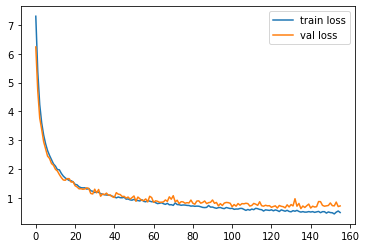

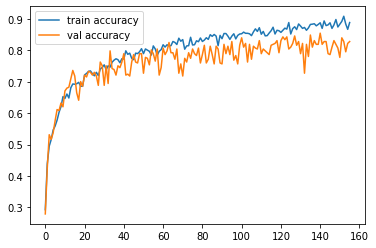

In [24]:
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(hist.history['accuracy'], label='train accuracy')
plt.plot(hist.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()

# Evaluation

In [25]:
model.evaluate(testX,testY)

11/11 [==============================] - 3s 298ms/step - loss: 0.7240 - accuracy: 0.8279


[0.7239608764648438, 0.8278931975364685]

# Reading Test Data

In [26]:
test_data = []
for i in os.listdir('/kaggle/input/nn23-sports-image-classification/Test'):
    img = cv.imread('/kaggle/input/nn23-sports-image-classification/Test/'+i)
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    img = cv.resize(img,(IMG_SIZE,IMG_SIZE))
    test_data.append(np.array(img))
test_data = np.array(test_data)
test_data = test_data/255.0

print(len(test_data))

688


# Predictions

In [30]:
pred = model.predict(test_data)
pred = np.argmax(pred,axis=1)
print(pred)
df = pd.DataFrame({'image_name':os.listdir('/kaggle/input/nn23-sports-image-classification/Test'),'Label':pred})
df.to_csv('submissionvmodel.csv',index=False)
df

[2 5 0 1 1 0 0 5 4 2 4 4 3 0 5 2 2 5 4 1 3 2 5 1 1 5 4 0 0 1 5 4 4 5 3 2 4
 1 2 4 2 5 5 1 0 4 5 3 0 5 2 0 5 2 0 1 1 3 5 1 0 2 4 1 2 1 0 3 2 1 1 1 3 1
 2 1 4 2 5 2 4 2 5 5 0 0 0 2 5 5 0 3 2 2 1 5 2 0 2 4 0 3 1 3 0 2 2 3 3 0 2
 3 2 3 1 5 2 0 2 4 2 2 1 1 2 2 1 5 3 0 0 1 4 5 5 5 1 2 2 2 1 1 5 2 3 4 0 3
 5 1 2 0 2 4 2 2 2 5 5 2 5 1 5 2 5 1 5 1 3 1 2 2 2 1 3 2 5 2 3 2 4 3 1 2 5
 0 1 0 0 2 2 3 5 1 0 5 1 1 1 1 5 1 1 1 1 2 4 2 2 1 1 4 4 2 1 1 5 5 1 3 1 1
 1 5 1 1 2 3 0 0 0 0 1 2 4 4 5 5 2 1 2 2 1 1 5 4 5 3 5 2 1 5 4 1 2 4 2 5 1
 3 5 5 1 1 3 5 5 5 4 5 1 5 5 5 1 5 3 2 5 5 4 1 3 1 4 5 2 0 0 4 0 3 1 1 1 1
 2 1 3 4 1 1 3 0 5 2 1 4 1 1 5 2 1 0 3 1 1 4 0 3 2 1 1 5 4 1 2 0 0 1 3 1 2
 0 3 0 0 5 1 5 2 1 1 5 1 5 3 1 1 0 1 1 2 3 1 5 0 2 1 2 1 5 1 3 2 5 2 2 2 1
 0 1 5 1 5 3 1 4 2 4 0 1 0 2 2 2 1 3 5 5 1 3 2 1 2 1 3 4 2 2 1 2 4 1 3 2 1
 4 1 3 1 5 0 2 2 5 3 1 2 5 1 2 2 3 4 0 2 4 1 5 2 4 3 4 5 0 3 1 4 0 1 1 1 2
 0 1 3 2 1 0 0 2 1 1 1 0 1 3 3 2 1 1 0 3 1 2 1 3 3 2 5 5 2 2 1 3 2 0 5 5 1
 2 1 0 0 3 5 0 1 5 3 5 5 

,image_name,Label
0,623.jpg,2
1,208.jpg,5
2,473.jpg,0
3,333.jpg,1
4,537.jpg,1
...,...,...
683,364.jpg,3
684,90.jpg,1
685,599.jpg,4
686,25.jpg,4


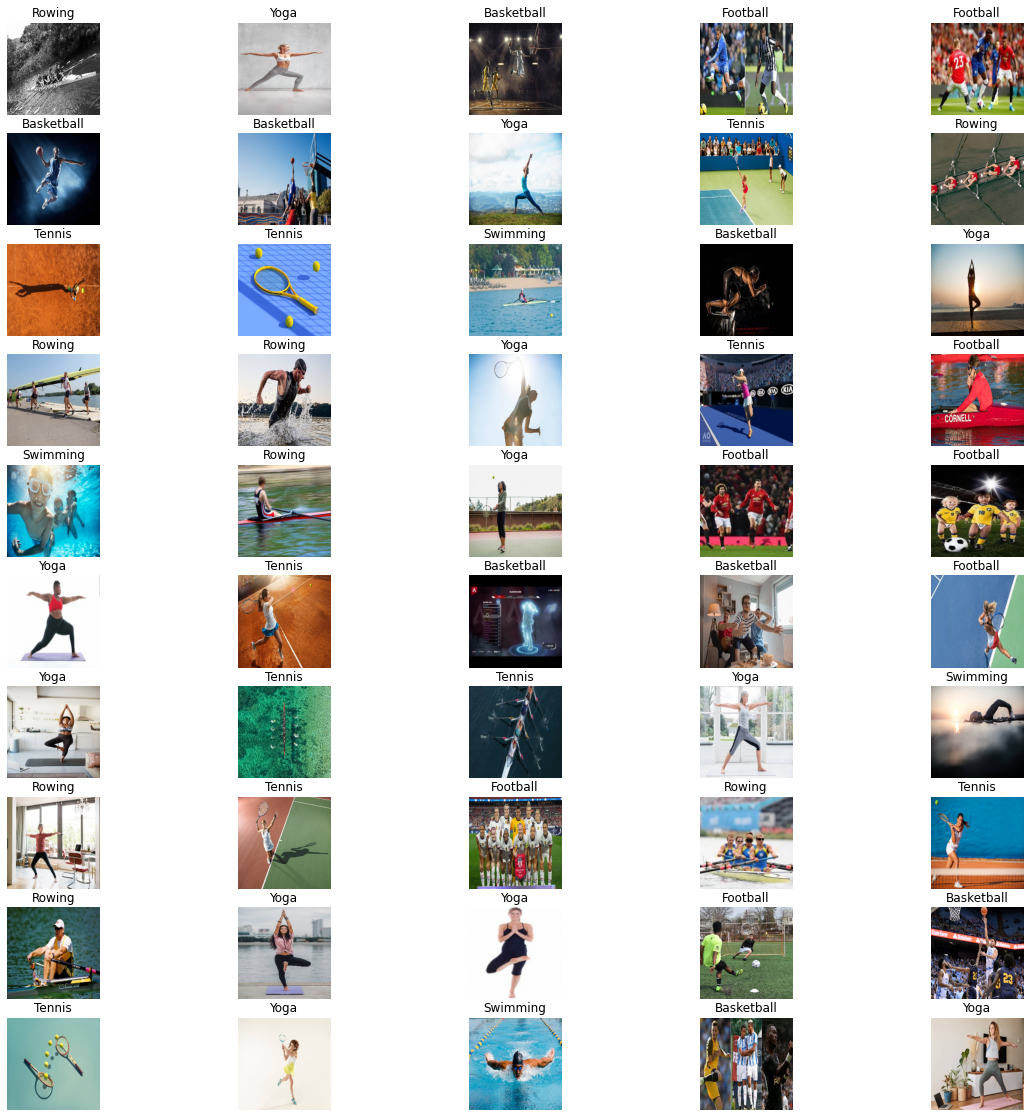

In [31]:
pred = le.inverse_transform(pred)
plt.figure(figsize=(20,20))
for i in range(50):
    plt.subplot(10,5,i+1)
    plt.imshow(test_data[i])
    plt.title(pred[i])
    plt.axis('off')
plt.show()

In [32]:
model.save('modelvmodel.h5')
import pickle
f = open('label_encoder.pkl', "wb")
f.write(pickle.dumps(le))
f.close()